In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/carvana-image-masking-challenge" directory.

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'metadata.csv', 'train_masks.csv', 'sample_submission.csv', 'train_masks']


In [23]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

metadata.csv
sample_submission.csv
test
train
train_masks
train_masks.csv



In [24]:
# Load all the necessary libraries
import numpy as np 
import gzip
import os 
from os.path import basename
import glob
import time 
import cv2
import pandas as pd 
import random
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import imresize
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from keras.models import Model 
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.optimizers import Adam, SGD 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras import backend as K

K.set_image_dim_ordering('th') # Theano dimension ordering in this code


In [25]:
INPUT_PATH='../input/'
print(os.getcwd())
dims=[128,128]
img_rows=dims[0]
img_cols=dims[1]
train=sorted(glob.glob(INPUT_PATH+'train/*.jpg'))
masks=sorted(glob.glob(INPUT_PATH+'train_masks/*.gif'))
test=sorted(glob.glob(INPUT_PATH+'test/*.jpg'))
print('Number of training images: ', len(train), 'Number of corresponding masks: ', len(masks), 'Number of test images: ', len(test))

meta=pd.read_csv(INPUT_PATH+'metadata.csv')
mask_df=pd.read_csv(INPUT_PATH+'train_masks.csv')
ids_train=mask_df['img'].map(lambda s: s.split('_')[0]).unique()
print('Length of ids_train ', len(ids_train))

/kaggle/working
Number of training images:  5088 Number of corresponding masks:  5088 Number of test images:  100064
Length of ids_train  318


In [26]:
mask_df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


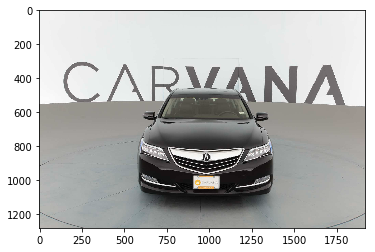

In [27]:
image = cv2.imread(INPUT_PATH+"train/00087a6bd4dc_01.jpg")
plt.imshow(image)
plt.show()

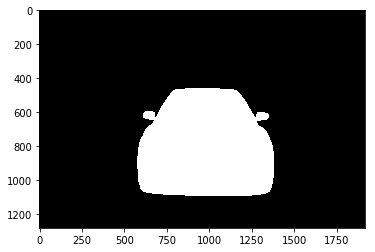

In [28]:
img = Image.open(INPUT_PATH+'train_masks/00087a6bd4dc_01_mask.gif').convert('RGB')
plt.imshow(img)
plt.show()

In [29]:
img2mask=np.array(img)
print(img2mask.shape)
print(image.shape)

(1280, 1918, 3)
(1280, 1918, 3)


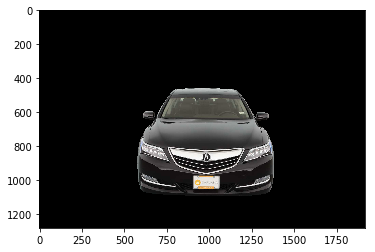

In [30]:
masked_img=cv2.bitwise_and(image,img2mask)
plt.imshow(masked_img)

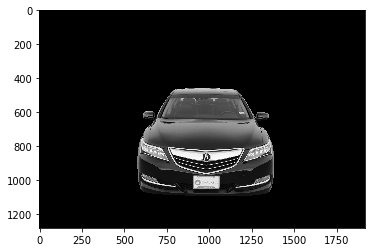

In [31]:
masked_gray=cv2.cvtColor(masked_img,cv2.COLOR_BGR2GRAY)
plt.imshow(masked_gray, cmap='gray')

In [32]:
masked_gray.shape

(1280, 1918)

In [33]:
#cv2.imshow('masked_gray',masked_gray)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [34]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection=K.sum(y_true_f * y_pred_f)
    return(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_mp(y_true, y_pred):
    y_true_f=y_true.flatten()
    y_pred_f=y_pred.flatten()
    intersection = np.sum(y_true_f*y_pred_f)
    return(2. * intersection + smooth)/(np.sum(y_pred_f) + mp.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [35]:
def get_layer(inputs, pixel, pool=True):
    conv = Conv2D(pixel, (3, 3), padding="same", activation='relu')(inputs)
    conv = Conv2D(pixel, (3 ,3), padding="same", activation='relu')(conv)
    if pool:
        pool = MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        pool = None
    return conv, pool

In [36]:
def get_unet():
    inputs = Input((3,img_rows, img_cols))
    conv1 = Conv2D(32, (3, 3), padding="same", activation='relu')(inputs)    
    conv1 = Conv2D(32, (3, 3), padding="same", activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding="same", activation='relu')(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation='relu')(conv2)    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", activation='relu')(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation='relu')(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding="same", activation='relu')(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation='relu')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    #      Concatenate(axis=3)([residual, upconv])
    conv6 = Conv2D(256, (3, 3), padding="same", activation='relu')(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation='relu')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), padding="same", activation='relu')(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation='relu')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), padding="same", activation='relu')(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation='relu')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), padding="same", activation='relu')(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation='relu')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)   #9

    model = Model(inputs=inputs, outputs=conv10)
    #      `Model(inputs=/input_19, outputs=sigmoid.0)`

    #model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])  #LUNA16
    model.compile(optimizer=Adam(5e-4), loss='binary_crossentropy', metrics=[dice_coef]) #ecobill

    return model

In [37]:
#split the train se into train and validation
train_images, validation_images = train_test_split(train, train_size=0.8, test_size=0.2)
print('Split into training set with ', len(train_images), ' images anf validation set with ', len(validation_images), ' images')

Split into training set with  4070  images anf validation set with  1018  images


In [38]:
#utility function to convert greyscale inages to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

#generator that we will use to read data from the directory
def data_gen_small(data_dir, masks, images, batch_size, dims):
    """ 
    data_dir: where the actual images are kept
    mask_dir: where the actual masks are kept 
    images: the filenames of the images wi want to generate batches from 
    batch_size: self explanatory
    dims: the dimensions in which wi want to rescale our images
    
    Image.resize(size, resample=0)
    
    Returns a resized copy of this image.
    Parameters: 
    
    size - The requested size in pixels, as a 2-tuple: (width, height).
    resample - An optional resampling filter. This can be one of PIL.Image.NEAREST,
    PIL.Image.BOX, PIL.Image.HAMMING, PIL.Image.BICUBIC or PIL.Image.LANCZOS
    If omitted, or if the image has mode "1" or "P", it is set PIL.Image.NEAREST
    """
    while True:
        ix=np.random.choice(np.arange(len(images)), batch_size)
        imgs = []
        labels = []
        for i in ix:
            # images
            original_img = cv2.imread(images[i])
            
            resized_img = imresize(original_img, dims + [3]) #this looks like TensorFlow ordering
            array_img = resized_img/255
            array_img = array_img.swapaxes(0, 2)
            imgs.append(array_img)
            #imgs is a numpy array with dim: (batch size X 128 X 128 3)
            #print('shape of imgs ', array_img.shape)
            # masks
            try:
                mask_filename = basename(images[i])
                no_extension = os.path.splitext(mask_filename)[0]
                correct_mask = INPUT_PATH + 'train_masks/' + no_extension + '_mask.gif'
                original_mask = Image.open(correct_mask).convert('L')
                data = np.asarray(original_mask, dtype="int32")
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = resized_mask / 255
                labels.append(array_mask)
            except Exception as e:
                labels=None
            
        imgs = np.array(imgs)
        labels = np.array(labels)
        try:
            relabel = labels.reshape(-1, dims[0], dims[1], 1)
            relabel = relabel.swapaxes(1, 3)
        except Exception as e:
            relabel=labels
        yield imgs, relabel

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Size of batch:  2
shape of img  (2, 3, 128, 128) number dimensions:  3
shape of msk  (2, 1, 128, 128) number dimensions:  3


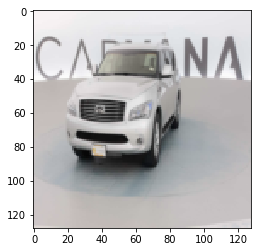

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


resized up:  (1280, 1918, 3)
resized swapaxes:  (1918, 1280, 3)
resized swapaxes shape[-1]:  3


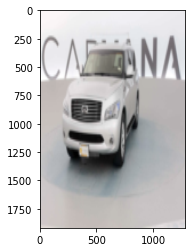

(2, 128, 128, 1)


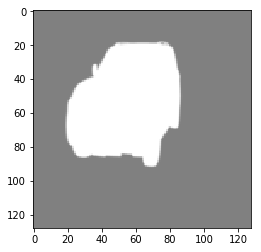

In [39]:
train_gen = data_gen_small(INPUT_PATH + 'train/', masks, train_images, 2, dims) 
img, msk = next(train_gen)
print('Size of batch: ', len(img))
print('shape of img ', img.shape, 'number dimensions: ', img[0].ndim)
print('shape of msk ', msk.shape, 'number dimensions: ', msk[0].ndim)
newshape = img[0].swapaxes(0,2)
plt.imshow(newshape)
plt.show()

#try resize up 

resized_img = imresize(img[0], [1280, 1918]+[3])
print('resized up: ', resized_img.shape)
newshape = resized_img.swapaxes(0,1)
print('resized swapaxes: ', newshape.shape)
print('resized swapaxes shape[-1]: ', newshape.shape[-1])

plt.imshow(newshape)
plt.show()

newshape = msk.swapaxes(1,3)
print(newshape.shape)
plt.imshow(grey2rgb(newshape[0]), alpha=0.5)
plt.show()

In [40]:
# create an instance of a validation generator:
validation_gen = data_gen_small(INPUT_PATH + 'train/', masks, validation_images, 4, dims) 

In [41]:
# define and compile the model
model = get_unet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 128, 128) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 128, 128) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 32, 64, 64)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 

In [42]:
# fit the model and check dice_coef on validation data as end of each epoch
model.fit_generator(train_gen, steps_per_epoch=50, epochs=35, validation_data=validation_gen, validation_steps=50)

Epoch 1/35


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


50/50 [==============================] - 22s 432ms/step - loss: 0.4084 - dice_coef: 0.3480 - val_loss: 0.3417 - val_dice_coef: 0.4135
Epoch 2/35
50/50 [==============================] - 18s 366ms/step - loss: 0.2355 - dice_coef: 0.6430 - val_loss: 0.2001 - val_dice_coef: 0.6334
Epoch 3/35
50/50 [==============================] - 18s 368ms/step - loss: 0.1591 - dice_coef: 0.7580 - val_loss: 0.1221 - val_dice_coef: 0.8475
Epoch 4/35
50/50 [==============================] - 18s 369ms/step - loss: 0.0964 - dice_coef: 0.8574 - val_loss: 0.0885 - val_dice_coef: 0.8673
Epoch 5/35
50/50 [==============================] - 19s 375ms/step - loss: 0.0822 - dice_coef: 0.8817 - val_loss: 0.0781 - val_dice_coef: 0.9013
Epoch 6/35
50/50 [==============================] - 19s 384ms/step - loss: 0.0820 - dice_coef: 0.8847 - val_loss: 0.0782 - val_dice_coef: 0.8913
Epoch 7/35
50/50 [==============================] - 19s 376ms/step - loss: 0.0848 - dice_coef: 0.8754 - val_loss: 0.0709 - val_dice_coef: 0.9

In [43]:
img, msk = next(validation_gen)
print(img.shape)
predicted_mask = model.predict(img)
predicted_mask.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(4, 3, 128, 128)


(4, 1, 128, 128)

newshape shape  (4, 128, 128, 1)
grey shape  (128, 128, 3)


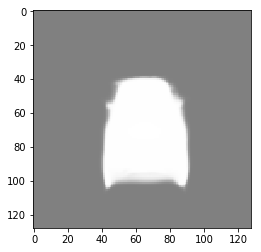

In [44]:
newshape = predicted_mask.swapaxes(1,3)
print('newshape shape ', newshape.shape)
grey = grey2rgb(newshape[3])
print('grey shape ', grey.shape)
plt.imshow(grey, alpha = 0.5)
plt.show()

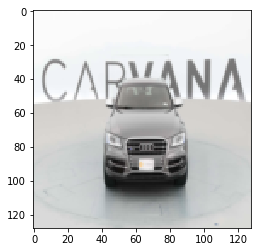

In [45]:
newshape = img[3].swapaxes(0,2)
plt.imshow(newshape)
plt.show()

**Prediction on the unseen data set**

In [46]:
validation_test = data_gen_small(INPUT_PATH + 'test/', masks, test, 4, dims) 
img_tst, msk_tst = next(validation_test)
print(img_tst.shape)
predicted_mask_tst = model.predict(img_tst)
predicted_mask_tst.shape

(4, 3, 128, 128)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(4, 1, 128, 128)

newshape shape  (4, 128, 128, 1)
grey shape  (128, 128, 3)


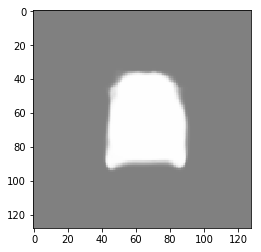

In [47]:
newshape_tst = predicted_mask_tst.swapaxes(1,3)
print('newshape shape ', newshape_tst.shape)
grey_tst = grey2rgb(newshape_tst[3])
print('grey shape ', grey_tst.shape)
plt.imshow(grey_tst, alpha = 0.5)
plt.show()

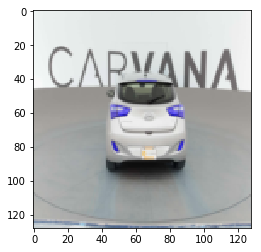

In [48]:
newshape_tst = img_tst[3].swapaxes(0,2)
plt.imshow(newshape_tst)
plt.show()

newshape shape  (4, 128, 128, 1)
grey shape  (128, 128, 3)


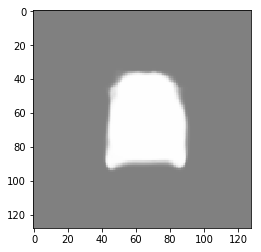

In [52]:
newshape_tst = predicted_mask_tst.swapaxes(1,3)
print('newshape shape ', newshape_tst.shape)
grey_tst = grey2rgb(newshape_tst[3])
print('grey shape ', grey_tst.shape)
plt.imshow(grey_tst, alpha = 0.5)
plt.show()

In [51]:
print(grey_tst)

[[[5.4073991e-04 5.4073991e-04 5.4073991e-04]
  [3.5256412e-06 3.5256412e-06 3.5256412e-06]
  [3.8247549e-06 3.8247549e-06 3.8247549e-06]
  ...
  [2.7922661e-06 2.7922661e-06 2.7922661e-06]
  [9.5374435e-07 9.5374435e-07 9.5374435e-07]
  [7.1971022e-05 7.1971022e-05 7.1971022e-05]]

 [[1.2697288e-06 1.2697288e-06 1.2697288e-06]
  [8.1075441e-10 8.1075441e-10 8.1075441e-10]
  [1.6093206e-09 1.6093206e-09 1.6093206e-09]
  ...
  [3.4769101e-10 3.4769101e-10 3.4769101e-10]
  [2.8209218e-11 2.8209218e-11 2.8209218e-11]
  [5.1353798e-08 5.1353798e-08 5.1353798e-08]]

 [[4.5036071e-08 4.5036071e-08 4.5036071e-08]
  [1.1799321e-11 1.1799321e-11 1.1799321e-11]
  [7.1279371e-11 7.1279371e-11 7.1279371e-11]
  ...
  [3.4965650e-12 3.4965650e-12 3.4965650e-12]
  [7.0577801e-14 7.0577801e-14 7.0577801e-14]
  [6.5854683e-10 6.5854683e-10 6.5854683e-10]]

 ...

 [[1.3012097e-07 1.3012097e-07 1.3012097e-07]
  [2.8995478e-10 2.8995478e-10 2.8995478e-10]
  [1.3436501e-10 1.3436501e-10 1.3436501e-10]
  ..

In [50]:
np.savetxt('test.txt', grey_tst)

ValueError: Expected 1D or 2D array, got 3D array instead